In [1]:
import numpy as np
import gensim.downloader as api
from scipy.stats import spearmanr
import os
from cuml.manifold import TSNE
import cudf
import numpy as np
import cupy as cp

In [2]:
class ReducedEmbeddingModel: 
    def __init__(self, vectors, index_to_key):
        self.vectors = vectors
        self.index_to_key = index_to_key
        self.key_to_index = {word: idx for idx, word in enumerate(index_to_key)}
    
    def __getitem__(self, word):
        if word in self.key_to_index:
            return self.vectors[self.key_to_index[word]]
        raise KeyError(f"Word '{word}' not found in vocabulary")
    
    def __contains__(self, word):
        return word in self.key_to_index

def load_glove_model(file_path):
    """Loads GloVe embeddings from a text file."""
    index_to_key = []
    vectors = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.split()
            word = parts[0]
            vector = np.array(parts[1:], dtype=np.float32)
            index_to_key.append(word)
            vectors.append(vector)
    vectors = np.vstack(vectors)
    return ReducedEmbeddingModel(vectors, index_to_key)

    
import time

def tsne_dimensionality_reduction(embeddings, target_dim, perplexity, learning_rate=200):
    """
    Reduces dimensions of embeddings using GPU-accelerated t-SNE.
      
    Parameters:
        embeddings (numpy.ndarray): Input high-dimensional embeddings (e.g., FastText) as a NumPy array.
        target_dim (int): Number of dimensions for the reduced space. Default is 2.
        perplexity (float): t-SNE perplexity parameter. Default is 30.
        learning_rate (float): Learning rate for optimization. Default is 200.

    Returns:
        numpy.ndarray: Reduced dimensionality embeddings.
    """
    print(f"Loading embeddings into GPU memory and initializing t-SNE with {target_dim} dimensions...")

    # Convert embeddings to a GPU DataFrame (cudf)
    embeddings_gpu = cudf.DataFrame.from_records(embeddings)

    # Initialize GPU-accelerated t-SNE
    tsne = TSNE(
        n_components=target_dim,
        perplexity=perplexity,
        learning_rate=learning_rate,
        random_state=42,  # For reproducibility
        verbose=1         # Enables progress output
    )

    print("Starting t-SNE dimensionality reduction...")
    start_time = time.time()  # Start timing

    # Perform dimensionality reduction
    reduced_embeddings = tsne.fit_transform(embeddings_gpu)

    end_time = time.time()  # End timing
    elapsed_time = end_time - start_time
    print(f"t-SNE completed in {elapsed_time:.2f} seconds.")

    return reduced_embeddings.to_pandas().to_numpy()  # Convert back to NumPy array if needed

# Load SimLex-999 word similarity data
def load_simlex_999(file_path):
    """Loads SimLex-999 and returns word pairs with similarity scores."""
    data = []
    with open(file_path, 'r') as file:
        next(file)  # Skip the header
        for line in file:
            parts = line.strip().split('\t')
            word1, word2, similarity_score = parts[0], parts[1], float(parts[3])
            data.append((word1, word2, similarity_score))
    return data

# Cosine similarity function for similarity evaluation
def cosine_similarity(v1, v2):
    """Calculates cosine similarity between two vectors."""
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)
    if norm1 == 0 or norm2 == 0:
        return 0
    return np.dot(v1, v2) / (norm1 * norm2)

# Evaluate embeddings on the SimLex-999 data
def evaluate_embeddings(model, word_pairs):
    """Evaluates embeddings using SimLex-999 data and Spearman correlation."""
    predicted_scores = []
    true_scores = []

    for word1, word2, true_score in word_pairs:
        if word1 in model and word2 in model:
            sim_score = cosine_similarity(model[word1], model[word2])
            predicted_scores.append(sim_score)
            true_scores.append(true_score)

    # Calculate Spearman correlation for word similarity performance
    correlation, _ = spearmanr(true_scores, predicted_scores)
    return correlation

In [3]:
glove_file_path = '/teamspace/uploads/glove.6B.300d.txt'  # Update this path to your GloVe file
simlex_file_path = '/teamspace/studios/pca/SimLex-999.txt'  # Update this path to your SimLex-999 file
target_dim = 2  # Adjust target_dim as needed for testing (e.g., 150, 100, 50)

In [4]:
print("Loading GloVe model...")
original_model = load_glove_model(glove_file_path)

Loading GloVe model...


In [5]:
word_pairs = load_simlex_999(simlex_file_path)

In [6]:
# Initialize a dictionary to store results for each perplexity value
results = {}
best_result = -100.0
optimized_embeddings1 = None

# List of perplexity values to evaluate
perplexities = [30]
# Perform t-SNE and evaluate embeddings for each perplexity value
for perplexity in perplexities:
    print(f"\nPerforming t-SNE with perplexity={perplexity}...")
    
    # Perform t-SNE dimensionality reduction
    reduced_embeddings = tsne_dimensionality_reduction(original_model.vectors, target_dim=2, perplexity=perplexity, learning_rate=200)
    
    # Create a dictionary with the reduced embeddings for evaluation
    reduced_model = {word: reduced_embeddings[i] for i, word in enumerate(original_model.index_to_key)}
    
    # Evaluate the reduced embeddings on SimLex-999
    correlation = evaluate_embeddings(reduced_model, word_pairs)
    
    # Store results
    results[perplexity] = correlation

    if(correlation > best_result):
        best_result = correlation
        optimized_embeddings1 = reduced_embeddings
    
    # Print Spearman correlation for the current perplexity
    print(f"Spearman Correlation for perplexity={perplexity}: {correlation:.4f}")

# Print a summary of all results
print("\nSummary of Spearman correlations across perplexities:")
for perplexity, correlation in results.items():
    print(f"Perplexity={perplexity}: Spearman Correlation={correlation:.4f}")

print("BEST Spearman Correlation = ", best_result)


Performing t-SNE with perplexity=30...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 54.17 seconds.
Spearman Correlation for perplexity=30: 0.0210

Summary of Spearman correlations across perplexities:
Perplexity=30: Spearman Correlation=0.0210
BEST Spearman Correlation =  0.020980104430962612


In [6]:
# Initialize a dictionary to store results for each perplexity value
results = {}
best_result = -100.0
optimized_embeddings1 = None

# List of perplexity values to evaluate
perplexities = [5, 15, 25, 35, 45, 55, 65, 75, 85, 95]
# Perform t-SNE and evaluate embeddings for each perplexity value
for perplexity in perplexities:
    print(f"\nPerforming t-SNE with perplexity={perplexity}...")
    
    # Perform t-SNE dimensionality reduction
    reduced_embeddings = tsne_dimensionality_reduction(original_model.vectors, target_dim=2, perplexity=perplexity, learning_rate=200)
    
    # Create a dictionary with the reduced embeddings for evaluation
    reduced_model = {word: reduced_embeddings[i] for i, word in enumerate(original_model.index_to_key)}
    
    # Evaluate the reduced embeddings on SimLex-999
    correlation = evaluate_embeddings(reduced_model, word_pairs)
    
    # Store results
    results[perplexity] = correlation

    if(correlation > best_result):
        best_result = correlation
        optimized_embeddings1 = reduced_embeddings
    
    # Print Spearman correlation for the current perplexity
    print(f"Spearman Correlation for perplexity={perplexity}: {correlation:.4f}")

# Print a summary of all results
print("\nSummary of Spearman correlations across perplexities:")
for perplexity, correlation in results.items():
    print(f"Perplexity={perplexity}: Spearman Correlation={correlation:.4f}")

print("BEST Spearman Correlation = ", best_result)


Performing t-SNE with perplexity=5...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 54.31 seconds.
Spearman Correlation for perplexity=5: 0.1138

Performing t-SNE with perplexity=15...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 54.83 seconds.
Spearman Correlation for perplexity=15: 0.1660

Performing t-SNE with perplexity=25...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 54.97 seconds.
Spearman Correlation for perplexity=25: 0.1300

Performing t-SNE with perplexity=35...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 55.56 seconds.
Spearman Correlation for perplexity=35: 0.0948

Performing t-SNE with perplexity=45...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 56.31 seconds.
Spearman Correlation for perplexity=45: 0.0385

Performing t-SNE with perplexity=55...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 56.03 seconds.
Spearman Correlation for perplexity=55: 0.0945

Performing t-SNE with perplexity=65...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 56.72 seconds.
Spearman Correlation for perplexity=65: 0.0933

Performing t-SNE with perplexity=75...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 56.44 seconds.
Spearman Correlation for perplexity=75: 0.0049

Performing t-SNE with perplexity=85...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 56.75 seconds.
Spearman Correlation for perplexity=85: -0.0277

Performing t-SNE with perplexity=95...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 56.13 seconds.
Spearman Correlation for perplexity=95: 0.0338

Summary of Spearman correlations across perplexities:
Perplexity=5: Spearman Correlation=0.1138
Perplexity=15: Spearman Correlation=0.1660
Perplexity=25: Spearman Correlation=0.1300
Perplexity=35: Spearman Correlation=0.0948
Perplexity=45: Spearman Correlation=0.0385
Perplexity=55: Spearman Correlation=0.0945
Perplexity=65: Spearman Correlation=0.0933
Perplexity=75: Spearman Correlation=0.0049
Perplexity=85: Spearman Correlation=-0.0277
Perplexity=95: Spearman Correlation=0.0338
BEST Spearman Correlation =  0.1659752542858248


In [7]:
# Initialize a dictionary to store results for each perplexity value
results = {}
best_result = -100.0
optimized_embeddings2 = None

# List of perplexity values to evaluate
perplexities = [5, 15, 25, 35, 45, 55, 65, 75, 85, 95]
# Perform t-SNE and evaluate embeddings for each perplexity value
for perplexity in perplexities:
    print(f"\nPerforming t-SNE with perplexity={perplexity}...")
    
    # Perform t-SNE dimensionality reduction
    reduced_embeddings = tsne_dimensionality_reduction(original_model.vectors, target_dim=2, perplexity=perplexity, learning_rate=200)
    
    # Create a dictionary with the reduced embeddings for evaluation
    reduced_model = {word: reduced_embeddings[i] for i, word in enumerate(original_model.index_to_key)}
    
    # Evaluate the reduced embeddings on SimLex-999
    correlation = evaluate_embeddings(reduced_model, word_pairs)
    
    # Store results
    results[perplexity] = correlation

    if(correlation > best_result):
        best_result = correlation
        optimized_embeddings2 = reduced_embeddings
    
    # Print Spearman correlation for the current perplexity
    print(f"Spearman Correlation for perplexity={perplexity}: {correlation:.4f}")

# Print a summary of all results
print("\nSummary of Spearman correlations across perplexities:")
for perplexity, correlation in results.items():
    print(f"Perplexity={perplexity}: Spearman Correlation={correlation:.4f}")

print("BEST Spearman Correlation = ", best_result)


Performing t-SNE with perplexity=5...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 55.88 seconds.
Spearman Correlation for perplexity=5: 0.1399

Performing t-SNE with perplexity=15...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 56.76 seconds.
Spearman Correlation for perplexity=15: 0.1507

Performing t-SNE with perplexity=25...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 57.04 seconds.
Spearman Correlation for perplexity=25: 0.0298

Performing t-SNE with perplexity=35...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 57.22 seconds.
Spearman Correlation for perplexity=35: 0.0412

Performing t-SNE with perplexity=45...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 56.36 seconds.
Spearman Correlation for perplexity=45: 0.0276

Performing t-SNE with perplexity=55...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 57.18 seconds.
Spearman Correlation for perplexity=55: 0.0796

Performing t-SNE with perplexity=65...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 56.24 seconds.
Spearman Correlation for perplexity=65: 0.1047

Performing t-SNE with perplexity=75...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 57.36 seconds.
Spearman Correlation for perplexity=75: 0.0358

Performing t-SNE with perplexity=85...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 57.41 seconds.
Spearman Correlation for perplexity=85: 0.0874

Performing t-SNE with perplexity=95...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 57.03 seconds.
Spearman Correlation for perplexity=95: 0.0374

Summary of Spearman correlations across perplexities:
Perplexity=5: Spearman Correlation=0.1399
Perplexity=15: Spearman Correlation=0.1507
Perplexity=25: Spearman Correlation=0.0298
Perplexity=35: Spearman Correlation=0.0412
Perplexity=45: Spearman Correlation=0.0276
Perplexity=55: Spearman Correlation=0.0796
Perplexity=65: Spearman Correlation=0.1047
Perplexity=75: Spearman Correlation=0.0358
Perplexity=85: Spearman Correlation=0.0874
Perplexity=95: Spearman Correlation=0.0374
BEST Spearman Correlation =  0.15066146034046385


In [8]:
# Initialize a dictionary to store results for each perplexity value
results = {}
best_result = -100.0
optimized_embeddings3 = None

# List of perplexity values to evaluate
perplexities = [5, 15, 25, 35, 45, 55, 65, 75, 85, 95]
# Perform t-SNE and evaluate embeddings for each perplexity value
for perplexity in perplexities:
    print(f"\nPerforming t-SNE with perplexity={perplexity}...")
    
    # Perform t-SNE dimensionality reduction
    reduced_embeddings = tsne_dimensionality_reduction(original_model.vectors, target_dim=2, perplexity=perplexity, learning_rate=200)
    
    # Create a dictionary with the reduced embeddings for evaluation
    reduced_model = {word: reduced_embeddings[i] for i, word in enumerate(original_model.index_to_key)}
    
    # Evaluate the reduced embeddings on SimLex-999
    correlation = evaluate_embeddings(reduced_model, word_pairs)
    
    # Store results
    results[perplexity] = correlation

    if(correlation > best_result):
        best_result = correlation
        optimized_embeddings3 = reduced_embeddings
    
    # Print Spearman correlation for the current perplexity
    print(f"Spearman Correlation for perplexity={perplexity}: {correlation:.4f}")

# Print a summary of all results
print("\nSummary of Spearman correlations across perplexities:")
for perplexity, correlation in results.items():
    print(f"Perplexity={perplexity}: Spearman Correlation={correlation:.4f}")

print("BEST Spearman Correlation = ", best_result)


Performing t-SNE with perplexity=5...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 54.87 seconds.
Spearman Correlation for perplexity=5: 0.0640

Performing t-SNE with perplexity=15...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 56.88 seconds.
Spearman Correlation for perplexity=15: 0.0542

Performing t-SNE with perplexity=25...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 56.44 seconds.
Spearman Correlation for perplexity=25: 0.0876

Performing t-SNE with perplexity=35...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 57.13 seconds.
Spearman Correlation for perplexity=35: -0.0006

Performing t-SNE with perplexity=45...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 57.05 seconds.
Spearman Correlation for perplexity=45: 0.0504

Performing t-SNE with perplexity=55...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 57.02 seconds.
Spearman Correlation for perplexity=55: 0.0535

Performing t-SNE with perplexity=65...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 57.19 seconds.
Spearman Correlation for perplexity=65: 0.0478

Performing t-SNE with perplexity=75...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 56.97 seconds.
Spearman Correlation for perplexity=75: 0.0674

Performing t-SNE with perplexity=85...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 57.03 seconds.
Spearman Correlation for perplexity=85: 0.0959

Performing t-SNE with perplexity=95...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 56.46 seconds.
Spearman Correlation for perplexity=95: 0.0013

Summary of Spearman correlations across perplexities:
Perplexity=5: Spearman Correlation=0.0640
Perplexity=15: Spearman Correlation=0.0542
Perplexity=25: Spearman Correlation=0.0876
Perplexity=35: Spearman Correlation=-0.0006
Perplexity=45: Spearman Correlation=0.0504
Perplexity=55: Spearman Correlation=0.0535
Perplexity=65: Spearman Correlation=0.0478
Perplexity=75: Spearman Correlation=0.0674
Perplexity=85: Spearman Correlation=0.0959
Perplexity=95: Spearman Correlation=0.0013
BEST Spearman Correlation =  0.09593815568415685


In [9]:
# Initialize a dictionary to store results for each perplexity value
results = {}
best_result = -100.0
optimized_embeddings4 = None

# List of perplexity values to evaluate
perplexities = [5, 15, 25, 35, 45, 55, 65, 75, 85, 95]
# Perform t-SNE and evaluate embeddings for each perplexity value
for perplexity in perplexities:
    print(f"\nPerforming t-SNE with perplexity={perplexity}...")
    
    # Perform t-SNE dimensionality reduction
    reduced_embeddings = tsne_dimensionality_reduction(original_model.vectors, target_dim=2, perplexity=perplexity, learning_rate=200)
    
    # Create a dictionary with the reduced embeddings for evaluation
    reduced_model = {word: reduced_embeddings[i] for i, word in enumerate(original_model.index_to_key)}
    
    # Evaluate the reduced embeddings on SimLex-999
    correlation = evaluate_embeddings(reduced_model, word_pairs)
    
    # Store results
    results[perplexity] = correlation

    if(correlation > best_result):
        best_result = correlation
        optimized_embeddings4 = reduced_embeddings
    
    # Print Spearman correlation for the current perplexity
    print(f"Spearman Correlation for perplexity={perplexity}: {correlation:.4f}")

# Print a summary of all results
print("\nSummary of Spearman correlations across perplexities:")
for perplexity, correlation in results.items():
    print(f"Perplexity={perplexity}: Spearman Correlation={correlation:.4f}")

print("BEST Spearman Correlation = ", best_result)


Performing t-SNE with perplexity=5...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 56.66 seconds.
Spearman Correlation for perplexity=5: 0.1305

Performing t-SNE with perplexity=15...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 56.35 seconds.
Spearman Correlation for perplexity=15: 0.0565

Performing t-SNE with perplexity=25...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 56.33 seconds.
Spearman Correlation for perplexity=25: 0.1173

Performing t-SNE with perplexity=35...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 56.35 seconds.
Spearman Correlation for perplexity=35: 0.1112

Performing t-SNE with perplexity=45...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 57.07 seconds.
Spearman Correlation for perplexity=45: 0.0273

Performing t-SNE with perplexity=55...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 56.69 seconds.
Spearman Correlation for perplexity=55: 0.0873

Performing t-SNE with perplexity=65...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 56.55 seconds.
Spearman Correlation for perplexity=65: 0.0821

Performing t-SNE with perplexity=75...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 56.80 seconds.
Spearman Correlation for perplexity=75: 0.0622

Performing t-SNE with perplexity=85...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 56.88 seconds.
Spearman Correlation for perplexity=85: 0.0953

Performing t-SNE with perplexity=95...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 56.96 seconds.
Spearman Correlation for perplexity=95: 0.0228

Summary of Spearman correlations across perplexities:
Perplexity=5: Spearman Correlation=0.1305
Perplexity=15: Spearman Correlation=0.0565
Perplexity=25: Spearman Correlation=0.1173
Perplexity=35: Spearman Correlation=0.1112
Perplexity=45: Spearman Correlation=0.0273
Perplexity=55: Spearman Correlation=0.0873
Perplexity=65: Spearman Correlation=0.0821
Perplexity=75: Spearman Correlation=0.0622
Perplexity=85: Spearman Correlation=0.0953
Perplexity=95: Spearman Correlation=0.0228
BEST Spearman Correlation =  0.13052955552299902


In [10]:
# Initialize a dictionary to store results for each perplexity value
results = {}
best_result = -100.0
optimized_embeddings5 = None

# List of perplexity values to evaluate
perplexities = [5, 15, 25, 35, 45, 55, 65, 75, 85, 95]
# Perform t-SNE and evaluate embeddings for each perplexity value
for perplexity in perplexities:
    print(f"\nPerforming t-SNE with perplexity={perplexity}...")
    
    # Perform t-SNE dimensionality reduction
    reduced_embeddings = tsne_dimensionality_reduction(original_model.vectors, target_dim=2, perplexity=perplexity, learning_rate=200)
    
    # Create a dictionary with the reduced embeddings for evaluation
    reduced_model = {word: reduced_embeddings[i] for i, word in enumerate(original_model.index_to_key)}
    
    # Evaluate the reduced embeddings on SimLex-999
    correlation = evaluate_embeddings(reduced_model, word_pairs)
    
    # Store results
    results[perplexity] = correlation

    if(correlation > best_result):
        best_result = correlation
        optimized_embeddings5 = reduced_embeddings
    
    # Print Spearman correlation for the current perplexity
    print(f"Spearman Correlation for perplexity={perplexity}: {correlation:.4f}")

# Print a summary of all results
print("\nSummary of Spearman correlations across perplexities:")
for perplexity, correlation in results.items():
    print(f"Perplexity={perplexity}: Spearman Correlation={correlation:.4f}")

print("BEST Spearman Correlation = ", best_result)


Performing t-SNE with perplexity=5...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 56.74 seconds.
Spearman Correlation for perplexity=5: 0.0889

Performing t-SNE with perplexity=15...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 56.63 seconds.
Spearman Correlation for perplexity=15: 0.0772

Performing t-SNE with perplexity=25...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 56.81 seconds.
Spearman Correlation for perplexity=25: 0.0461

Performing t-SNE with perplexity=35...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 57.03 seconds.
Spearman Correlation for perplexity=35: 0.0885

Performing t-SNE with perplexity=45...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 56.44 seconds.
Spearman Correlation for perplexity=45: 0.0441

Performing t-SNE with perplexity=55...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 56.97 seconds.
Spearman Correlation for perplexity=55: 0.0544

Performing t-SNE with perplexity=65...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 56.62 seconds.
Spearman Correlation for perplexity=65: 0.0574

Performing t-SNE with perplexity=75...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 56.62 seconds.
Spearman Correlation for perplexity=75: 0.0157

Performing t-SNE with perplexity=85...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 56.36 seconds.
Spearman Correlation for perplexity=85: 0.0940

Performing t-SNE with perplexity=95...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 57.36 seconds.
Spearman Correlation for perplexity=95: 0.0270

Summary of Spearman correlations across perplexities:
Perplexity=5: Spearman Correlation=0.0889
Perplexity=15: Spearman Correlation=0.0772
Perplexity=25: Spearman Correlation=0.0461
Perplexity=35: Spearman Correlation=0.0885
Perplexity=45: Spearman Correlation=0.0441
Perplexity=55: Spearman Correlation=0.0544
Perplexity=65: Spearman Correlation=0.0574
Perplexity=75: Spearman Correlation=0.0157
Perplexity=85: Spearman Correlation=0.0940
Perplexity=95: Spearman Correlation=0.0270
BEST Spearman Correlation =  0.09404071644949805


In [16]:
import pandas as pd

# Save the 2D embeddings with word labels to a CSV file
def save_embeddings_to_csv(words, embeddings, file_path):
    print(f"Saving 2D embeddings to {file_path}...")
    df = pd.DataFrame(embeddings, columns=['x', 'y'])
    df['word'] = words
    df.to_csv(file_path, index=False)
    print("2D embeddings saved successfully.")

In [17]:
# Get words and their high-dimensional embeddings
words = original_model.index_to_key  # List of words in vocabulary
######### RENAME AS PER THE BEST RESULT
file_path="Glove_TSNE_2d_word_embeddings_1659.csv"
# Save the embeddings and words to a CSV file
######### UPDATE THE optimized_embeddings variable as per the best result
save_embeddings_to_csv(words, optimized_embeddings1, file_path)

Saving 2D embeddings to Glove_TSNE_2d_word_embeddings_1659.csv...


2D embeddings saved successfully.


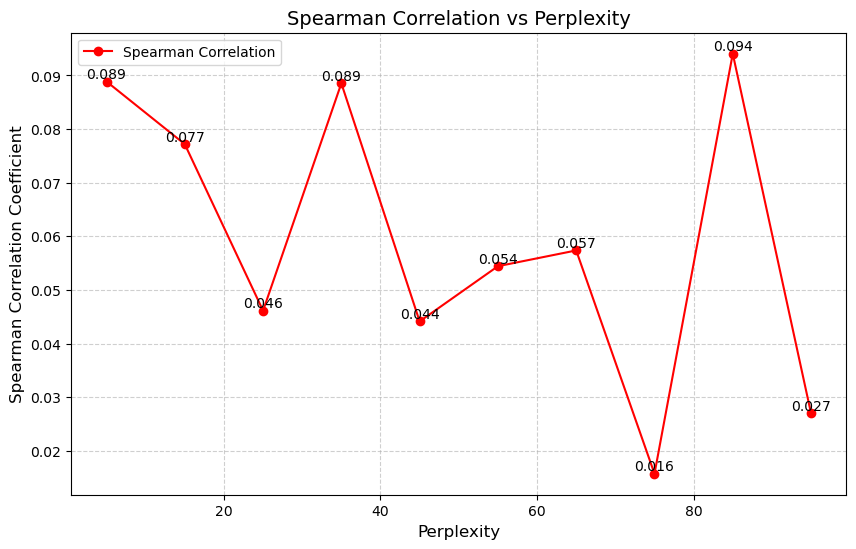

In [18]:
import matplotlib.pyplot as plt
# Define the perplexity values and their corresponding Spearman correlations
perplexities = [5, 15, 25, 35, 45, 55, 65, 75, 85, 95]
correlations = [results[perplexity] for perplexity in perplexities]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(perplexities, correlations, marker='o', linestyle='-', color='r', label="Spearman Correlation")

# Add labels and title
plt.title("Spearman Correlation vs Perplexity", fontsize=14)
plt.xlabel("Perplexity", fontsize=12)
plt.ylabel("Spearman Correlation Coefficient", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Annotate points
for i, (x, y) in enumerate(zip(perplexities, correlations)):
    plt.text(x, y, f"{y:.3f}", fontsize=10, ha='center', va='bottom')

# Show legend
plt.legend()

# Display the plot
plt.show()

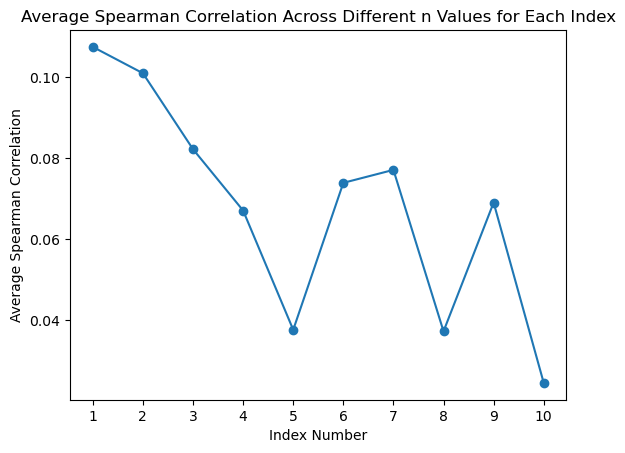

In [1]:
import matplotlib.pyplot as plt

# spearman_correlations_n5 = [0.2166, 0.1728, 0.1662, 0.2061, 0.2228, 0.1463, 0.2007, 0.1542, 0.2303, 0.1846]
# spearman_correlations_n10 = [0.2162, 0.2117, 0.2200, 0.1586, 0.1735, 0.1282, 0.1075, 0.1819, 0.1434, 0.1709]
# spearman_correlations_n15 = [0.2391, 0.2319, 0.1743, 0.1967, 0.2112, 0.2084, 0.1760, 0.1957, 0.1889, 0.1718]
# spearman_correlations_n20 = [0.2467, 0.2074, 0.1986, 0.2203, 0.1701, 0.1653, 0.1956, 0.1588, 0.1410, 0.1697]
# spearman_correlations_n25 = [0.2103, 0.2334, 0.2004, 0.1760, 0.2004, 0.2021, 0.1766, 0.2071, 0.1895, 0.1689]

spearman_correlations_list1 = [0.1138, 0.1660, 0.1300, 0.0948, 0.0385, 0.0945, 0.0933, 0.0049, -0.0277, 0.0338]
spearman_correlations_list2 = [0.1399, 0.1507, 0.0298, 0.0412, 0.0276, 0.0796, 0.1047, 0.0358, 0.0874, 0.0374]
spearman_correlations_list3 = [0.0640, 0.0542, 0.0876, -0.0006, 0.0504, 0.0535, 0.0478, 0.0674, 0.0959, 0.0013]
spearman_correlations_list4 = [0.1305, 0.0565, 0.1173, 0.1112, 0.0273, 0.0873, 0.0821, 0.0622, 0.0953, 0.0228]
spearman_correlations_list5 = [0.0889, 0.0772, 0.0461, 0.0885, 0.0441, 0.0544, 0.0574, 0.0157, 0.0940, 0.0270]

# Combine all lists into a single list of lists
# all_lists = [
#     spearman_correlations_n5,
#     spearman_correlations_n10,
#     spearman_correlations_n15,
#     spearman_correlations_n20,
#     spearman_correlations_n25,
# ]
all_lists = [
    spearman_correlations_list1,
    spearman_correlations_list2,
    spearman_correlations_list3,
    spearman_correlations_list4,
    spearman_correlations_list5,
]

# Calculate the average value for each index across all lists
index_averages = []
for i in range(len(spearman_correlations_list1)):  # Iterate through indices (0 to 9)
    index_values = [lst[i] for lst in all_lists]  # Get the value at index i from each list
    index_average = sum(index_values) / len(index_values)
    index_averages.append(index_average)

# Create a list of index numbers for the x-axis
index_numbers = list(range(1, len(spearman_correlations_list1) + 1))  # 1 to 10

# Plot the index averages in a line graph
plt.plot(index_numbers, index_averages, marker='o')

# Add labels and title
plt.xlabel("Index Number")
plt.ylabel("Average Spearman Correlation")
plt.title("Average Spearman Correlation Across Different n Values for Each Index")

# Customize the x-axis ticks
plt.xticks(index_numbers)

# Display the plot
plt.show()

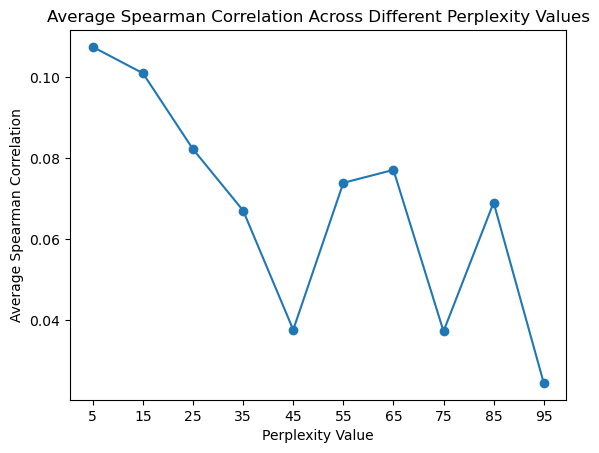

In [12]:
import matplotlib.pyplot as plt

spearman_correlations_list1 = [0.1138, 0.1660, 0.1300, 0.0948, 0.0385, 0.0945, 0.0933, 0.0049, -0.0277, 0.0338]
spearman_correlations_list2 = [0.1399, 0.1507, 0.0298, 0.0412, 0.0276, 0.0796, 0.1047, 0.0358, 0.0874, 0.0374]
spearman_correlations_list3 = [0.0640, 0.0542, 0.0876, -0.0006, 0.0504, 0.0535, 0.0478, 0.0674, 0.0959, 0.0013]
spearman_correlations_list4 = [0.1305, 0.0565, 0.1173, 0.1112, 0.0273, 0.0873, 0.0821, 0.0622, 0.0953, 0.0228]
spearman_correlations_list5 = [0.0889, 0.0772, 0.0461, 0.0885, 0.0441, 0.0544, 0.0574, 0.0157, 0.0940, 0.0270]

all_lists = [
    spearman_correlations_list1,
    spearman_correlations_list2,
    spearman_correlations_list3,
    spearman_correlations_list4,
    spearman_correlations_list5,
]

# Calculate the average value for each index across all lists
index_averages = []
for i in range(len(spearman_correlations_list1)):
    index_values = [lst[i] for lst in all_lists]
    index_average = sum(index_values) / len(index_values)
    index_averages.append(index_average)

# Create a list of perplexity values from 5 to 95 with intervals of 10
perplexity_values = list(range(5, 96, 10))  # [5, 15, 25, ..., 85, 95]

# Plot the index averages in a line graph
plt.plot(perplexity_values, index_averages, marker='o')

# Add labels and title
plt.xlabel("Perplexity Value")
plt.ylabel("Average Spearman Correlation")
plt.title("Average Spearman Correlation Across Different Perplexity Values")

# Customize the x-axis ticks
plt.xticks(perplexity_values)

# Display the plot
plt.show()